In [1]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test
from multitest import MultiTest

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from survival import evaluate_test_stats

### Dev

In [101]:
def test_gene(data, gene_name, T, stbl=False):
    """
    Evaluate all test statistics for comparing the survival curves
    for the two groups involving the response of :gene_name:
    Also, consolidate event times based on :T:.

    Args:
    :data: is the entire dataset containing the group division
            at minimum, :data: should contain the columns
            :gene_name:, `events`, `time`
    :gene_name:  the name of the column to test
    :T:    is the new maximal time interval. If T == -1 then we
            use the original times

    """
    if T > 0:
        dfr = reduce_time_resolution(two_groups_gene(data, gene_name), T)
    else:
        dfr = two_groups_gene(df, gene_name)
    r = evaluate_test_stats(dfr['at-risk1'].values, dfr['at-risk2'].values,
                            dfr['dead1'].values, dfr['dead2'].values,
                            stbl=stbl, randomize=False
                            )
    rrev = evaluate_test_stats(dfr['at-risk2'].values, dfr['at-risk1'].values,
                               dfr['dead2'].values, dfr['dead1'].values,
                               stbl=stbl, randomize=False)

    r['name'] = gene_name
    rrev['name'] = gene_name

    r['x0'] = dfr['at-risk1'].max()
    r['y0'] = dfr['at-risk2'].max()
    r['lam1'] = (np.log(dfr['at-risk1'].max()) - np.log(dfr['at-risk1'].min())) / T
    
    r['lam1'] = dfr['dead1'].sum() / dfr['at-risk1'].sum()
    r['lam2'] = dfr['dead2'].sum() / dfr['at-risk2'].sum()

    rdf = pd.DataFrame(r, index=[0])
    revdf = pd.DataFrame(rrev, index=[0])

    return rdf.join(revdf, rsuffix='_rev')


-2.8786376969772136


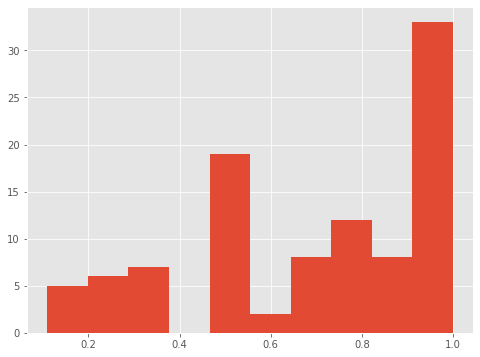

In [88]:

def sample_balanced_assignmet(T):
        """ Perfectly balanced assignment """
        a = np.random.rand(T)
        return a < np.median(a)

T = 100
stbl=False
df_test = df[['time', 'event']]
a = sample_balanced_assignmet( len(df_test))
df_test = pd.DataFrame({'random_sample' : a,
                       'time' : df['time'],
                       'event': df['event']})
#df_test.loc[:, 'random_sample'] = a
gene_name = 'random_sample'
dfr = reduce_time_resolution(two_groups_gene(df_test, gene_name), T)

Nt1, Nt2, Ot1, Ot2 = dfr['at-risk1'].values, dfr['at-risk2'].values, dfr['dead1'].values, dfr['dead2'].values

pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, alternative='greater')
mt = MultiTest(pvals, stbl=stbl)
# if not using stbl=False, then sometimes
# HC misses the significance of the strongest effect
print(mt.hc()[0])
dfreal =  pd.DataFrame({'Nt1':Nt1,'Nt2':Nt2, 'Ot1':Ot1, 'Ot2':Ot2, 'pval':pvals})

plt.hist(pvals)
plt.show()

-2.8009551950373095


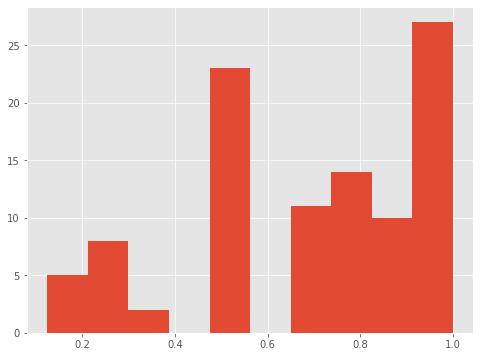

In [83]:
lam0 = 0.1
Nt1, Nt2 = sample_survival_poisson(T, Nt1.max(), Nt2.max(), np.ones(T) * lam0 / T, 0, 0)
Ot1 = -np.diff(Nt1)
Ot2 = -np.diff(Nt2)

pvals = multi_pvals(Nt1[:-1], Nt2[:-1], Ot1, Ot2, alternative='less')
mt = MultiTest(pvals, stbl=stbl)
# if not using stbl=False, then sometimes
# HC misses the significance of the strongest effect
print(mt.hc()[0])
dfsyn = pd.DataFrame({'Nt1':Nt1[:-1],'Nt2':Nt2[:-1], 'Ot1':Ot1, 'Ot2':Ot2, 'pval':pvals})

plt.hist(pvals)
plt.show()

0.22668210039869993


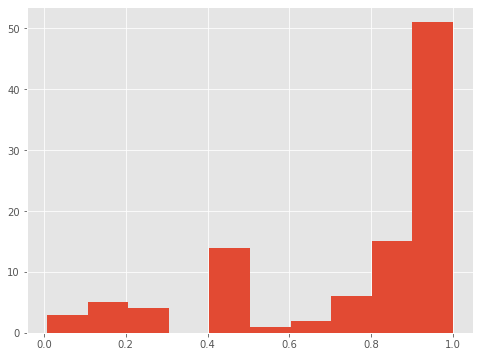

In [84]:
lam0 = .1
lamc = .7

Nt1, Nt2 = sample_survival_poisson(T, Nt1.max(), Nt2.max(), np.ones(T) * lam0 / T, 0, 0)

Ct1 = np.append(0, poisson.rvs(lamc, size=len(Nt1) - 1))
Ct2 = np.append(0, poisson.rvs(lamc, size=len(Nt2) - 1))
Ot1 = np.maximum(np.append(-np.diff(Nt1), 0) - Ct1, 0)
Ot2 = np.maximum(np.append(-np.diff(Nt2), 0) - Ct2, 0)

pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, alternative='less')
mt = MultiTest(pvals, stbl=stbl)
# if not using stbl=False, then sometimes
# HC misses the significance of the strongest effect
print(mt.hc()[0])
dfsyn = pd.DataFrame({'Nt1':Nt1,'Nt2':Nt2, 'Ot1':Ot1, 'Ot2':Ot2, 'pval':pvals})

plt.hist(pvals)
plt.show()


## Load Data:

In [14]:
df = pd.read_csv("./Data/SCNAB_groups_valid.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

div_probs = df.agg(['mean'])
thresh = 0.001
valid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) < thresh]
invalid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) > thresh]
df.drop(columns = invalid_genes + ['Unnamed: 0'])

assert(len(invalid_genes) == 0)

print("Removed: ", 9259 - len(valid_genes))

Removed:  557


## Report null values

In [5]:
def infmean(x):
    "mean ignoring inf values"
    return np.mean(np.ma.masked_invalid(x))

def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)


def infstd(x):
    return np.std(np.ma.masked_invalid(x))


def report_null_stats(df0, T, precision=5):
    dsp = df0.agg([q95, 'mean', 'std']).filter(
        ['log_rank_greater', 'hc_greater', 'x0', 'y0', 'lam1', 'lam2'])
    dsp.loc['std_95'] = [std_95(df0[c]) for c in dsp]

    print(np.round(dsp, precision))

    if 'lam1' in dsp:
        m = (infmean(df0['lam1']) + infmean(df0['lam1']))/2
        s = np.sqrt((infstd(df0['lam1']) ** 2 + infstd(df0['lam2']) ** 2) / 2)
        print("lam * T = ", np.round(m * T, precision))
        print("SE(lam*T) = ", np.round(s * T, precision))


In [6]:
T = 100
M = 10000
stbl = False
df0 = pd.read_csv(f'results/SCNAB_null_{stbl}_T{T}_M{M}.csv')

report_null_stats(df0, T)

        log_rank_greater  hc_greater          x0          y0
q95              1.60954    -0.04368  1534.00000  1535.00000
mean             0.01021    -1.23820  1534.00000  1535.00000
std              0.96888     0.82006     0.00000     0.00000
std_95           0.02104     0.01073     0.00059     0.00059


### Test

In [160]:
# stat per gene

acc = []
df0n = pd.DataFrame()
for c in tqdm(df0.groupby('name')):
    df0n = df0n.append({
        'name': c[0],
        'q95': pd.Series.quantile(c[1].hc_greater, .95),
        'hc_mean': c[1].hc_greater.mean(),
        'hc_std': c[1].hc_greater.std(),
        'q95_log_rank': pd.Series.quantile(c[1].log_rank_greater, .95),
    }, ignore_index=True)
df0n = df0n.set_index('name')

100%|██████████| 9259/9259 [00:24<00:00, 376.18it/s]


In [7]:
from real_data import simulate_null_data, test_gene

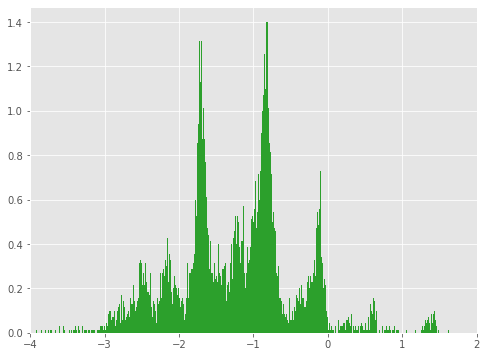

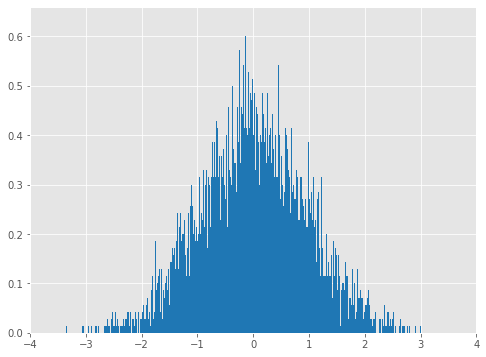

In [61]:
vals = list(df0.hc_greater) 
plt.hist(vals, bins = np.linspace(-4,3,1000), density=True, color='tab:green')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-4, 2])

remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"
plt.savefig(remote_dir + 'Figs/hc_hist.png')
plt.show()


vals = list(df0.log_rank_greater) 
plt.hist(vals, bins = np.linspace(-4,3,1000), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-4, 4])

plt.savefig(remote_dir + 'Figs/lr_hist.png')
plt.show()

In [62]:
df0

,Unnamed: 0,log_rank_greater,log_rank_pval_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,name,x0,y0,lam,log_rank_greater_rev,log_rank_pval_greater_rev,hc_greater_rev,fisher_greater_rev,min_p_greater_rev,berk_jones_greater_rev,wilcoxon_greater_rev,name_rev
0,0,-0.017963,0.507166,-1.705890,1.165512,2.784488,18.188752,0.481079,random_sample,1534.0,1535.0,0.001259,0.017963,0.492834,-1.717367,1.187168,2.776277,19.541929,0.962639,random_sample
1,1,-0.020607,0.508221,-1.729593,1.272340,2.767560,12.700796,0.590709,random_sample,1534.0,1535.0,0.001262,0.020607,0.491779,-1.520714,1.326144,2.210802,10.661488,0.807289,random_sample
2,2,0.752839,0.225773,-1.059996,1.385261,2.255784,10.184299,1.179725,random_sample,1534.0,1535.0,0.001276,-0.752839,0.774227,-1.748727,1.186952,2.740772,13.107451,0.367250,random_sample
3,3,0.622458,0.266821,-1.732420,1.260854,2.778595,17.072495,0.762690,random_sample,1534.0,1535.0,0.001257,-0.622458,0.733179,-1.741906,1.103043,2.758813,17.723837,0.628128,random_sample
4,4,0.547775,0.291923,-0.406166,1.248090,3.461698,18.888126,0.822544,random_sample,1534.0,1535.0,0.001264,-0.547775,0.708077,-2.759983,1.126019,1.923488,18.745184,0.578592,random_sample
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,-0.862025,0.805663,-2.508080,1.115639,2.081428,17.432211,0.780533,random_sample,1534.0,1535.0,0.001255,0.862025,0.194337,-0.827655,1.371283,3.482832,12.090422,0.612788,random_sample
9996,9996,1.217106,0.111782,-2.104850,1.325397,2.134032,11.660377,1.042858,random_sample,1534.0,1535.0,0.001286,-1.217106,0.888218,-3.584104,0.955451,1.668490,25.474197,0.434553,random_sample
9997,9997,1.154873,0.124071,-1.729218,1.416913,2.763835,9.136492,0.908791,random_sample,1534.0,1535.0,0.001260,-1.154873,0.875929,-2.086318,1.125697,2.215152,16.715747,0.515857,random_sample
9998,9998,-1.188861,0.882753,-1.659095,1.174447,2.189863,13.948982,0.374744,random_sample,1534.0,1535.0,0.001268,1.188861,0.117247,-0.822602,1.433186,3.493265,11.921495,1.163039,random_sample


In [6]:
T = 100
M = 10000
stbl = False
df0 = pd.read_csv(f'results/SCNAB_null_False_T{T}_M{M}.csv')

crit_vals = df0.agg([q95]).filter(
        ['log_rank_greater', 
         'hc_greater', 
         'hc_greater_rev', 
         'log_rank_greater_rev'])
crit_vals

,log_rank_greater,hc_greater,hc_greater_rev,log_rank_greater_rev
q95,1.609541,-0.043676,-0.048155,1.566986


In [23]:
# here we go over all genes:
stbl=False
T = 100

res = pd.DataFrame()
for gene_name in tqdm(gene_names):
   # try:
    r = test_gene(df, gene_name, T, stbl-stbl)
    res = res.append(r, ignore_index=True)
   # except:
        #print(f"Error in evaluating {gene_name}")
res.to_csv(f"results/SCNAB_{stbl}_T{T}.csv")

100%|██████████| 8702/8702 [32:46<00:00,  4.42it/s]


In [8]:
T = 100
stbl = False
res = pd.read_csv(f"results/SCNAB_greater_{stbl}_T{T}.csv")
#res = res[res.name.isin(gene_names)]

In [9]:
# analyze results

def empirical_pval(x, stat_name, df0):
    return np.minimum((np.sum(df0[stat_name].values >= x) ) / len(df0), 1)

LRt = crit_vals['log_rank_greater'].values[0]
HCt = crit_vals['hc_greater'].values[0]

log_rank_non = (res.log_rank_greater < LRt) & (res.log_rank_greater_rev < LRt)
log_rank_1side_strict = (res.log_rank_greater > LRt) & (res.log_rank_greater_rev < LRt)
log_rank_1side_strict_rev = (res.log_rank_greater < LRt) & (res.log_rank_greater_rev > LRt)
log_rank_2side = (res.log_rank_greater > LRt) | (res.log_rank_greater_rev > LRt)

log_rank_strict = log_rank_1side_strict | log_rank_1side_strict_rev

hc_non = (res.hc_greater < HCt) & (res.hc_greater_rev < HCt)
hc_1side_strict = (res.hc_greater > HCt) & (res.hc_greater_rev < HCt)
hc_1side_strict_rev = (res.hc_greater < HCt) & (res.hc_greater_rev > HCt)
hc_2side = (res.hc_greater > HCt) | (res.hc_greater_rev > HCt)

hc_strict = hc_1side_strict | hc_1side_strict_rev

print("Strictly one-sided effect:")
print("\tDiscoverable by HC: ", np.sum(hc_strict))
print("\tDiscoverable by LR: ", np.sum(log_rank_strict))

print("\tDiscoverable by HC and LR: ", np.sum(hc_strict & log_rank_strict))
print("\tDiscoverable by HC but not LR: ", np.sum(hc_strict & (1 - log_rank_strict) )   )
print("\tDiscoverable by LR but not HC: ", np.sum((1 - hc_strict) & ( log_rank_strict) )   )
print("\tDiscoverable by neigher HC nor LR: ", np.sum((1 - hc_strict) & (1 - log_rank_strict) )   )


print(" Either side effect:")

print("\tDiscoverable by HC: ", np.sum(hc_2side))
print("\tDiscoverable by LR: ", np.sum(log_rank_2side))


print("\tDiscoverable by HC and LR: ", np.sum(hc_2side & log_rank_2side))
print("\tDiscoverable by HC but not LR: ", np.sum(hc_2side & (1 - log_rank_2side) )   )
print("\tDiscoverable by LR but not HC: ", np.sum((1 - hc_2side) & ( log_rank_2side) )   )
print("\tDiscoverable by neigher HC nor LR: ", np.sum((1 - hc_2side) & (1 - log_rank_2side) )   )



INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Strictly one-sided effect:
	Discoverable by HC:  2015
	Discoverable by LR:  4485
	Discoverable by HC and LR:  1615
	Discoverable by HC but not LR:  400
	Discoverable by LR but not HC:  2870
	Discoverable by neigher HC nor LR:  3817
 Either side effect:
	Discoverable by HC:  2042
	Discoverable by LR:  4485
	Discoverable by HC and LR:  1634
	Discoverable by HC but not LR:  408
	Discoverable by LR but not HC:  2851
	Discoverable by neigher HC nor LR:  3809


### Arrange Results for presentation:

In [10]:
# use minimal P-value between both sides
res['log_rank_pval'] = [empirical_pval(v, 'log_rank_greater', df0) for v in res['log_rank_greater'].values]
res['log_rank_rev_pval'] = [empirical_pval(v, 'log_rank_greater_rev', df0) for v in res['log_rank_greater_rev'].values]
res['hc_greater_pval'] = [empirical_pval(v, 'hc_greater', df0) for v in res['hc_greater'].values]
res['hc_greater_rev_pval'] = [empirical_pval(v, 'hc_greater_rev', df0) for v in res['hc_greater_rev'].values]
res['hc_pval'] = np.minimum(res['hc_greater_pval'], res['hc_greater_rev_pval'])
res['log_rank_pval'] = np.minimum(res['log_rank_pval'], res['log_rank_rev_pval'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

In [11]:
# take only those discovered by HC but not LR:
resi = res[hc_strict & (1 - log_rank_strict)].sort_values('l-ratio').filter(['name', 'hc_greater', 'hc_greater_rev',
                                            'log_rank_greater', 'log_rank_greater_rev',
                                            'hc_pval', 'log_rank_pval', 'l-ratio'
                                           ])
len(resi) # 400

400

In [12]:
from real_data import reduce_time_resolution, two_groups_gene
from survival import (hypergeom_test, q95, multi_pvals, evaluate_test_stats)

def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.5):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct


def illustrate_survival_curve(df, gene_name, T, stbl=False):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=False)
    if stats['hc_greater'] < stats_rev['hc_greater']: # reverse groups
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1', 
                         'dead1': 'dead2', 'dead2': 'dead1',
                        'censored1': 'censored2', 'censored2': 'censored1'
                                 })
        temp = stats
        stats = stats_rev
        stats_rev = temp
        
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    #print("HC = ", hc)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True)
    
    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    cumc1 = dfg['censored1'].cumsum()
    cumc2 = dfg['censored2'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at-risk1'] - dfg['censored1']) / (dfg['at-risk1'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at-risk2'] - dfg['censored2']) / (dfg['at-risk2'].max() - cumc2)
    #dfg['censored1'] = dfg['at-risk1'] - dfg['']
        
    
    df_disp = dfg[fpval].rename(columns={'at-risk1' : 'at-risk X', 'at-risk2' : 'at-risk Y',
                                     'dead1' : 'events X', 'dead2' : 'events Y'
                                    })
    
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored1'] > 0
    ct2 = dfg['censored2'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored1'].max() / dfg.loc[ct1, 'censored1']).values
    s2 = 10 * (dfg.loc[ct2, 'censored2'].max() / dfg.loc[ct2, 'censored2']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1,'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2,'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)
    hc_pval = empirical_pval(stats['hc_greater'], 'hc_greater', df0)
    hc_pval_rev = empirical_pval(stats_rev['hc_greater'], 'hc_greater', df0)
    logrank_pval = empirical_pval(stats['log_rank_greater'], 'log_rank_greater', df0)

    st_HC = r"$\hat{p}(\mathrm{HC})$"
    st_HC_rev = r"$\hat{p}(\tilde{\mathrm{HC}})$"
    st_LR = r"$\hat{p}(\mathrm{LR})$"
    plt.title(rf"{gene_name}: {st_HC}={np.round(hc_pval,2)}, {st_HC_rev}={np.round(hc_pval_rev,2)}, {st_LR}={np.round(logrank_pval,2)}")
    #plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    plt.ylim([0.7, 1.01])
    
    return df_disp, dfg
    

400it [02:22,  2.81it/s]


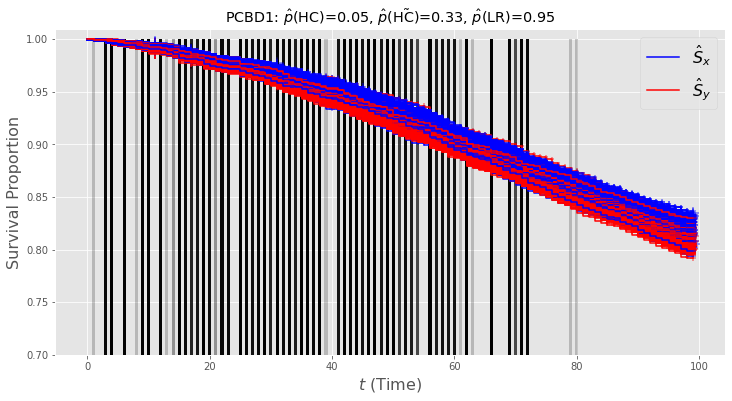

In [14]:
plt.rcParams['figure.figsize'] =  [12, 6]

resi['no_p'] = 0
for r in tqdm(resi.iterrows()):
    gene_name = r[1]['name']
    dfp, dfg = illustrate_survival_curve(df, gene_name, T, stbl=False)
    resi.loc[r[0],'no_p'] = len(dfp)

In [15]:
ls_rep = resi[resi['no_p'] >= 2].name.unique()
ls_rep

array(['DCK', 'ADSS', 'RCAN1', 'FNTA', 'SLCO3A1', 'KCTD9', 'ST6GALNAC5',
       'PIP5K1A', 'KLHL12', 'NFIB', 'VAMP4', 'KANK1', 'RGS14', 'ZMAT3',
       'SLC8A1', 'HIST1H3G', 'CTNNA1', 'TMEM38B', 'SIGMAR1', 'CATSPER2',
       'PPFIBP2', 'RNF7', 'DIRAS2', 'SLC5A12', 'SPAG9', 'EDC3', 'MED17',
       'UXT', 'FHL2', 'NTF3', 'PLCG2', 'EPB41L5', 'ATG7', 'NUDT13',
       'LRRC41', 'STX3', 'FBXO41', 'C11orf68', 'PREPL', 'PKDREJ',
       'ECHDC1', 'MYO18A', 'HIST1H4B', 'CANT1', 'PKNOX2', 'TMSB15B',
       'FURIN', 'RBPJ', 'KPNB1', 'OS9', 'SEC22A', 'ITPKC', 'POLDIP3',
       'OLAH', 'POLD4', 'ZNF778', 'SCRG1', 'BCLAF1', 'CCHCR1', 'NIT1',
       'PID1', 'SNAPC5', 'RAD21', 'HNRNPA3', 'SMG9', 'CCL20', 'CREB3L1',
       'FBXL12', 'TESK1', 'BCL9', 'CCL2', 'TUBAL3', 'AKR1B1', 'NFE2L3',
       'RHOQ', 'DYRK4', 'TIMM8B', 'UCK2', 'GRWD1', 'IFNAR2', 'MCAT',
       'NIPSNAP1', 'ICAM1', 'SARDH', 'ERGIC3', 'PAPSS1', 'PTPRJ',
       'CATSPERB', 'RBP1', 'TNFRSF12A', 'CUL2', 'RUSC1', 'OR7A5', 'CEP76',
       'SN

In [41]:
# select 10 and add two presented genes. 
in_paper = ['SIGMAR1', 'ST6GALANC5']
top_10 = resi[resi.name.isin(ls_rep)].sort_values('hc_greater', ascending=False).groupby('flip').head(5).name
resi_disp = resi[resi.name.isin(in_paper + list(top_10))]
resi_disp['hc'] = resi
resi_disp

<ipython-input-41-cf09522f5c53>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resi_disp['hc'] = resi


,name,hc_greater,hc_greater_rev,log_rank_greater,log_rank_greater_rev,hc_pval,log_rank_pval,l-ratio,no_p,flip,hc,log_rank
1878,DCK,1.996967,-1.280906,0.353713,-0.353713,0.0001,0.3593,0.000278,2,$>$ med,DCK,0.353713
192,ADSS,2.049119,-2.096883,1.522972,-1.522972,0.0001,0.0607,0.001647,2,$>$ med,ADSS,1.522972
3823,KCTD9,0.967720,-1.749968,0.410345,-0.410345,0.0117,0.3370,0.034718,2,$>$ med,KCTD9,0.410345
8249,VAMP4,1.000529,-1.712181,0.797585,-0.797585,0.0117,0.2072,0.056467,4,$>$ med,VAMP4,0.797585
3309,HIST1H3G,-0.125919,0.514606,-0.245831,0.245831,0.0274,0.3937,0.069596,3,$<$ med,HIST1H3G,0.245831
7755,TMEM38B,-0.342276,0.463764,0.199520,-0.199520,0.0297,0.4195,0.070799,3,$<$ med,TMEM38B,0.199520
6819,SIGMAR1,-1.626986,1.024563,-0.945808,0.945808,0.0116,0.1615,0.071827,6,$<$ med,SIGMAR1,0.945808
7065,SMG9,-0.074811,0.127971,-0.703540,0.703540,0.0398,0.2294,0.173496,5,$<$ med,SMG9,0.703540
2601,FBXL12,1.015047,-1.461040,1.509527,-1.509527,0.0115,0.0619,0.185784,4,$>$ med,FBXL12,1.509527
5325,PDE6D,-0.048303,0.188883,-1.149826,1.149826,0.0383,0.1173,0.326513,10,$<$ med,PDE6D,1.149826


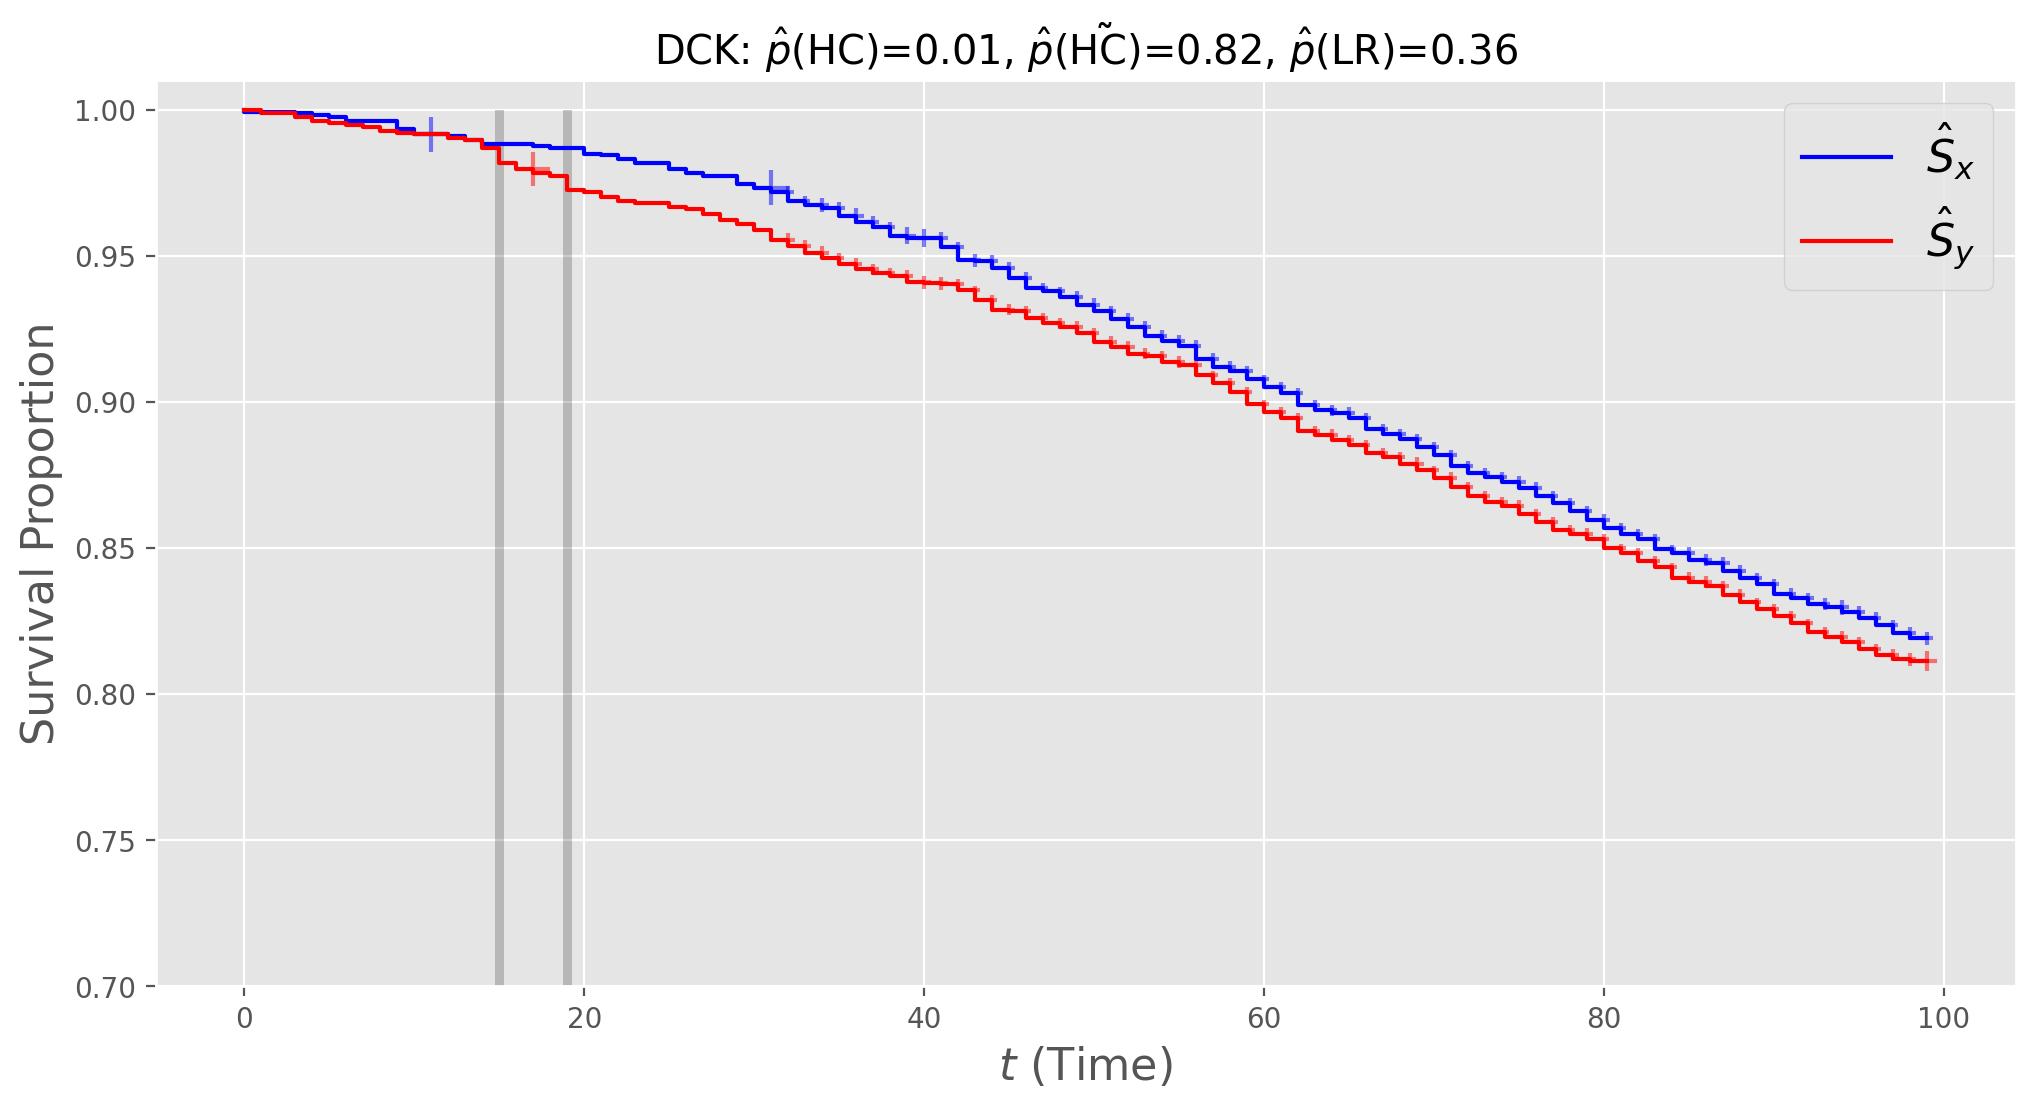

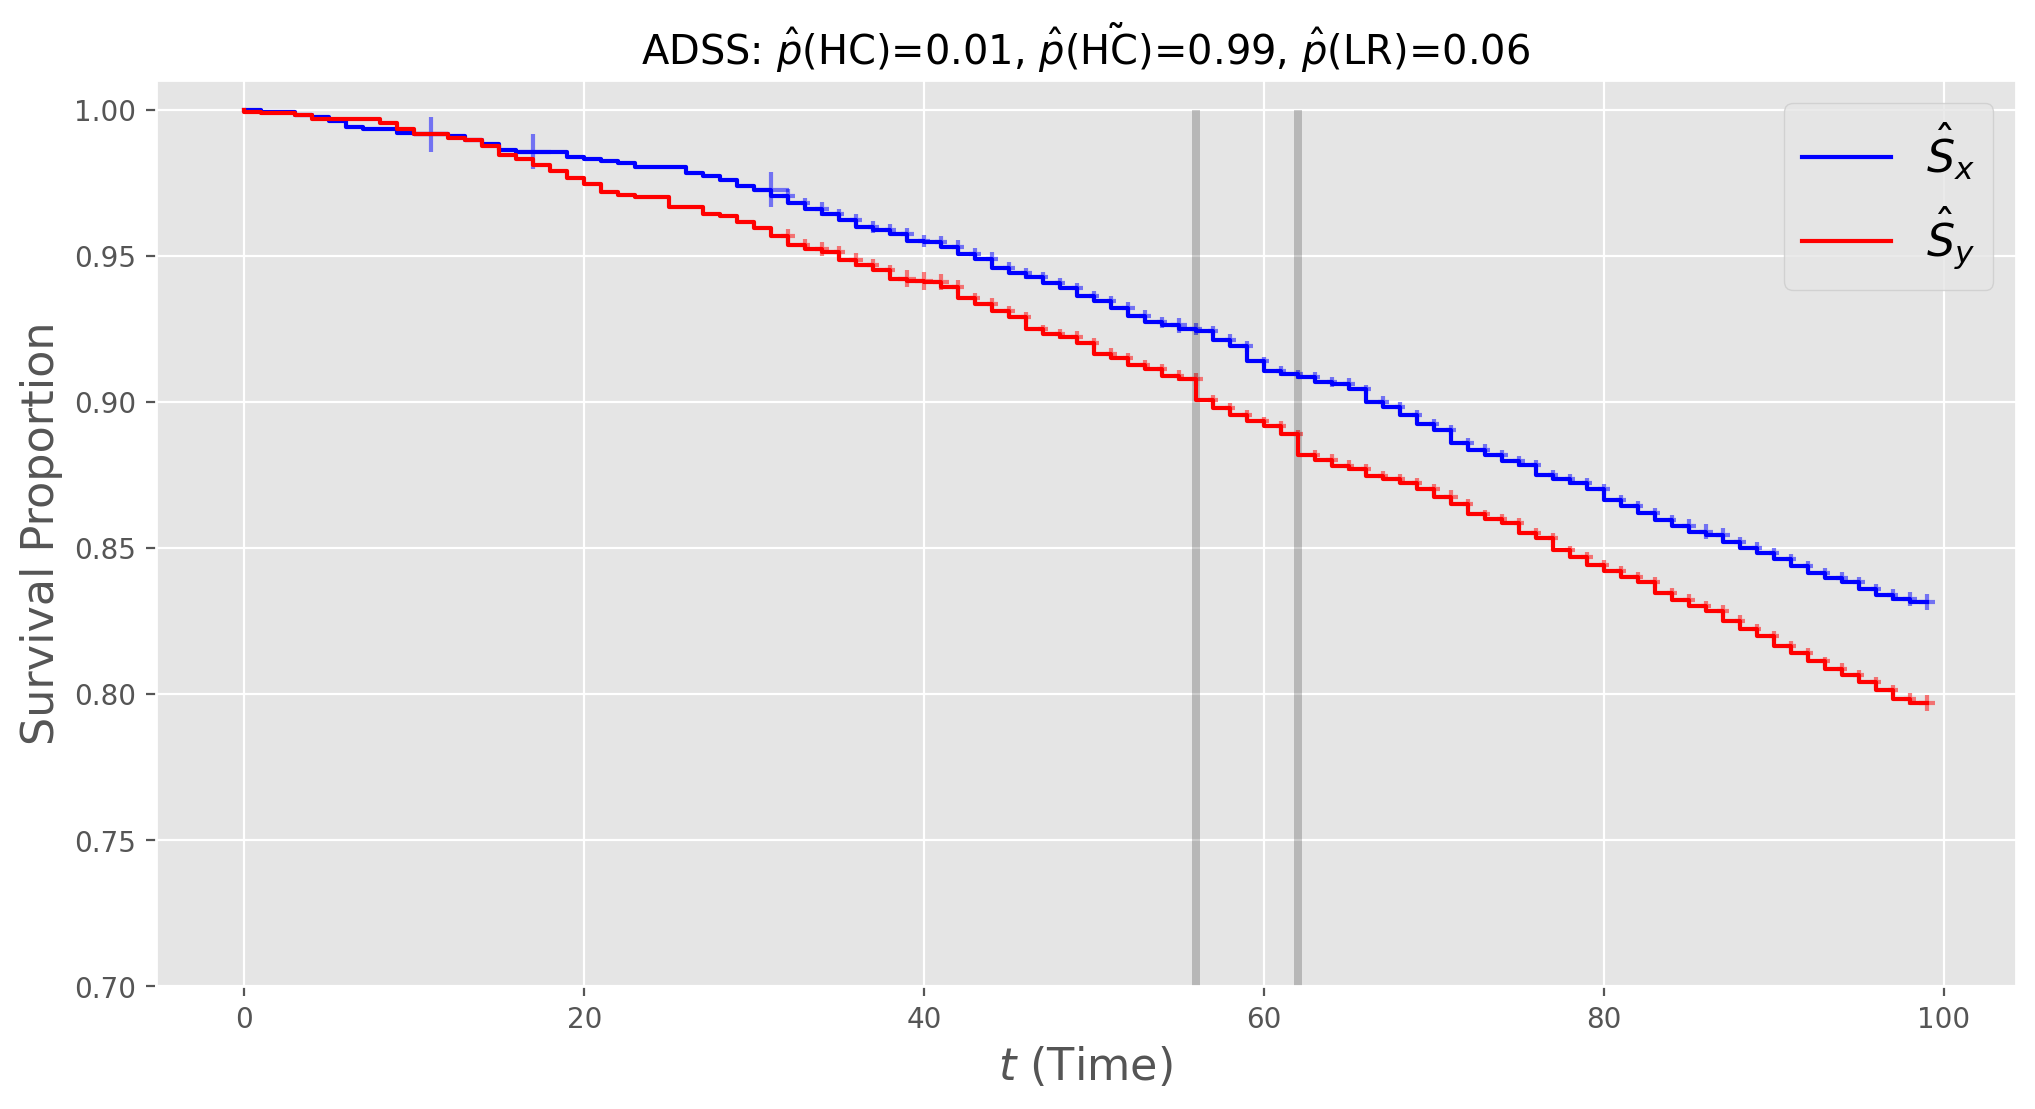

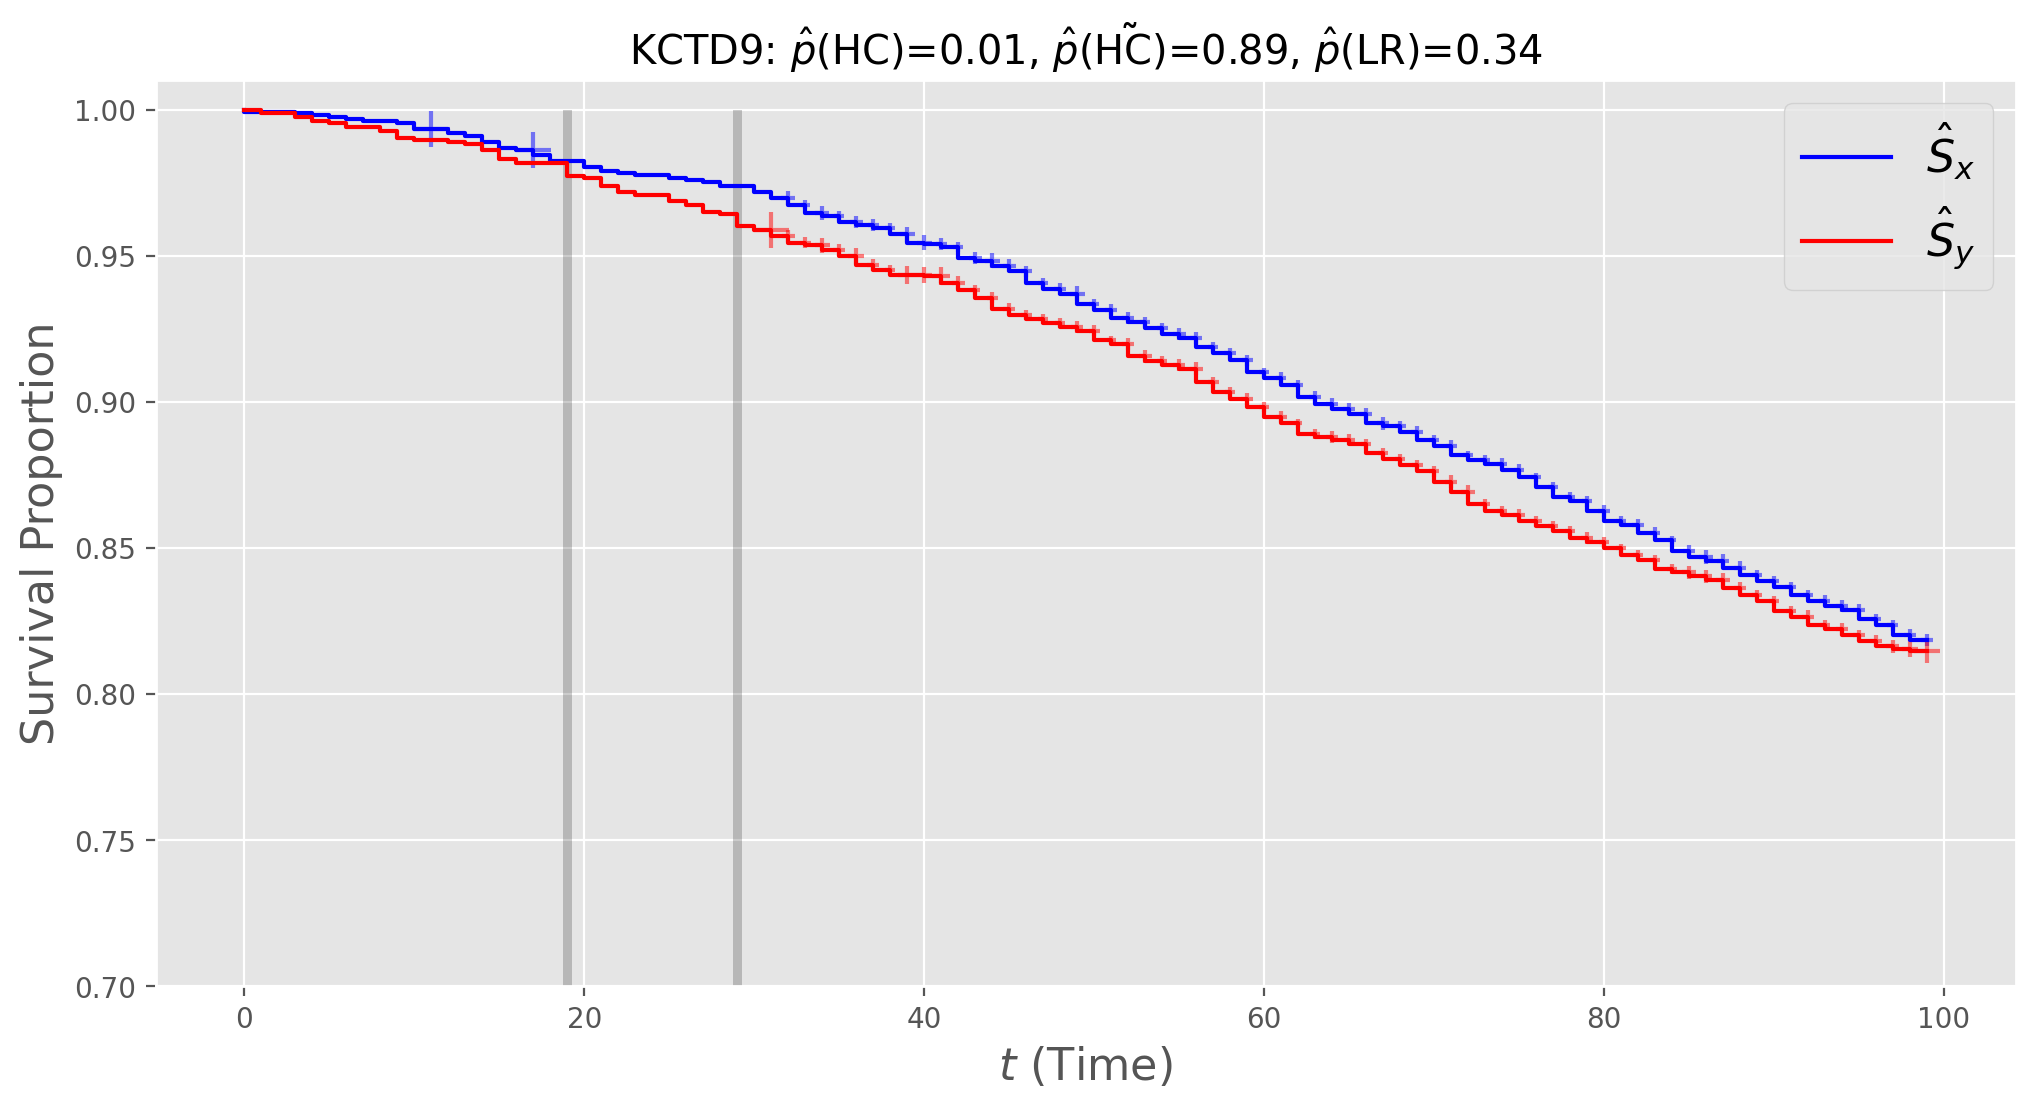

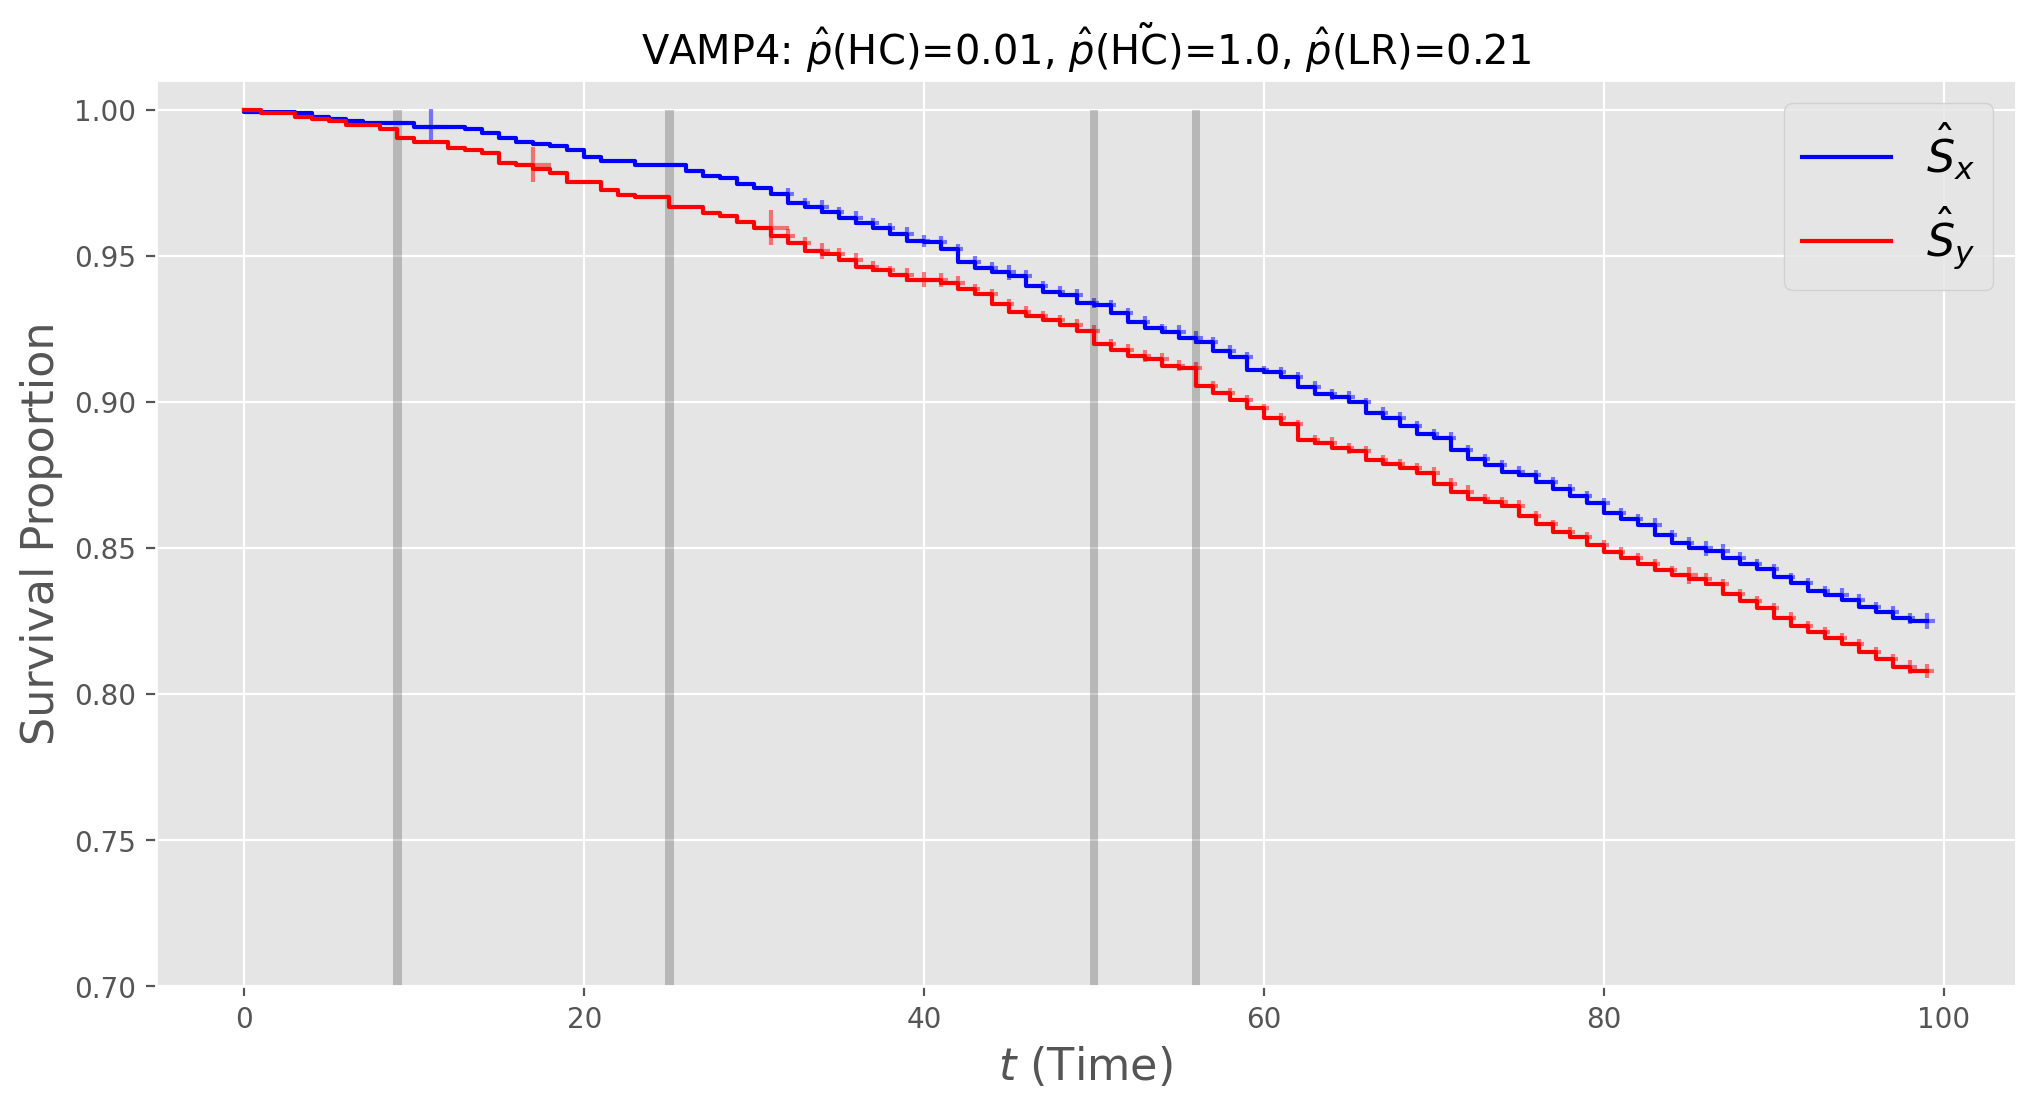

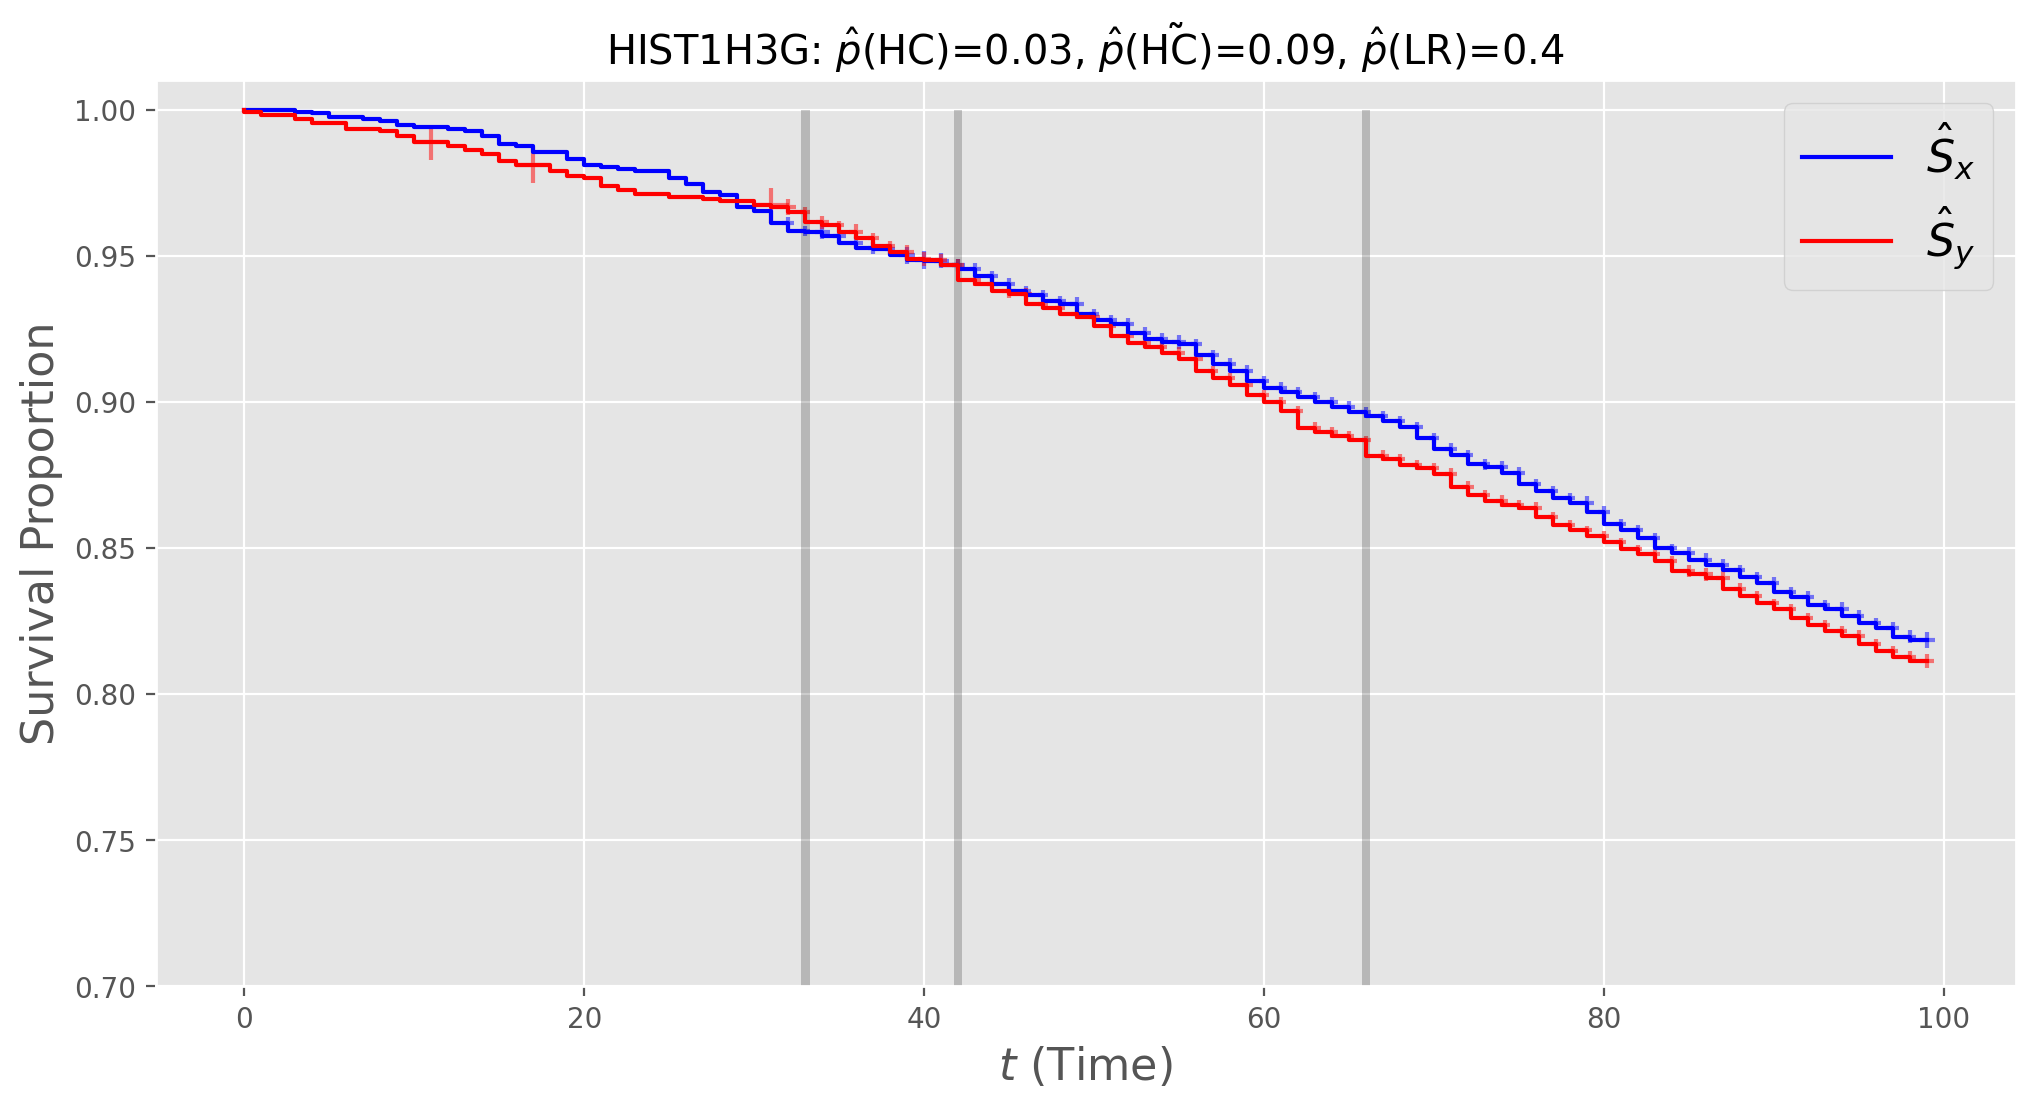

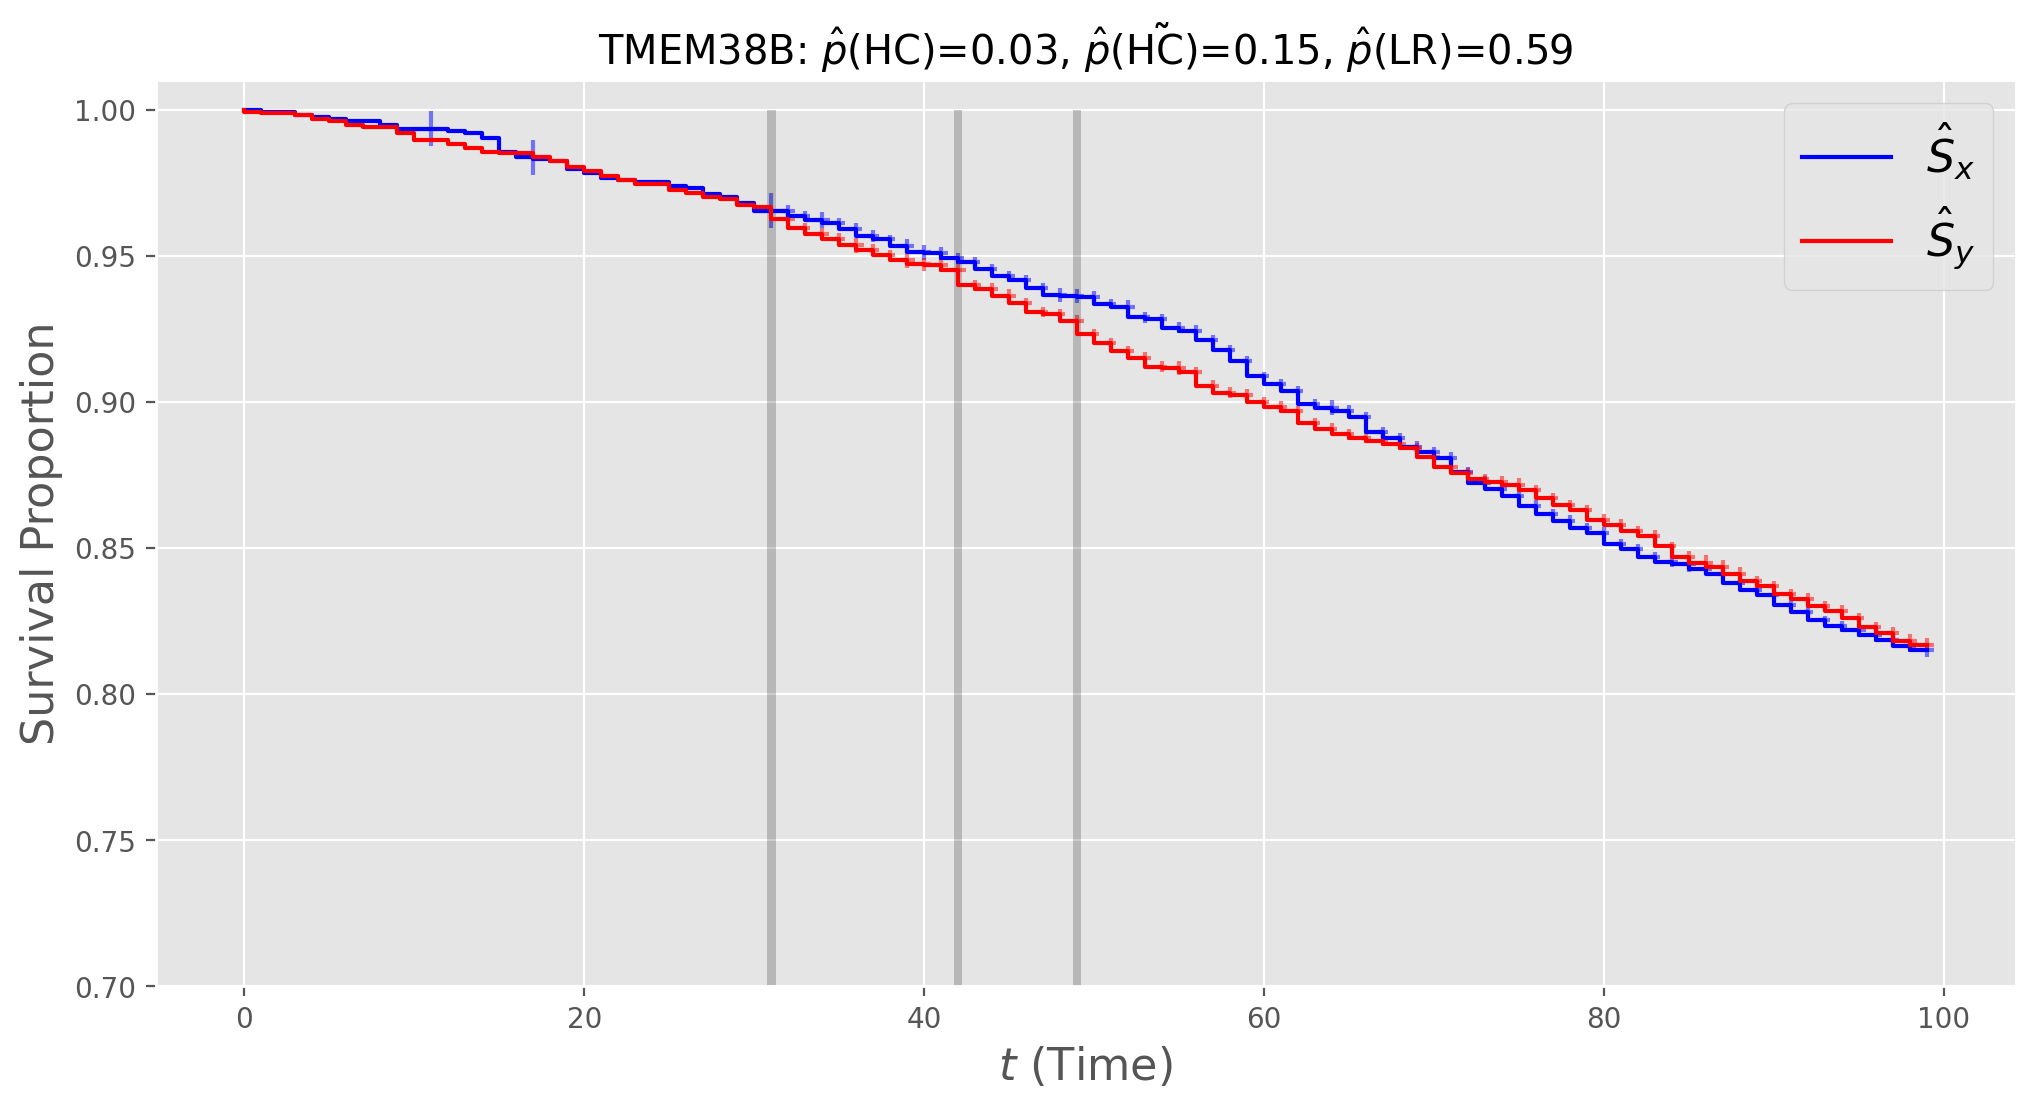

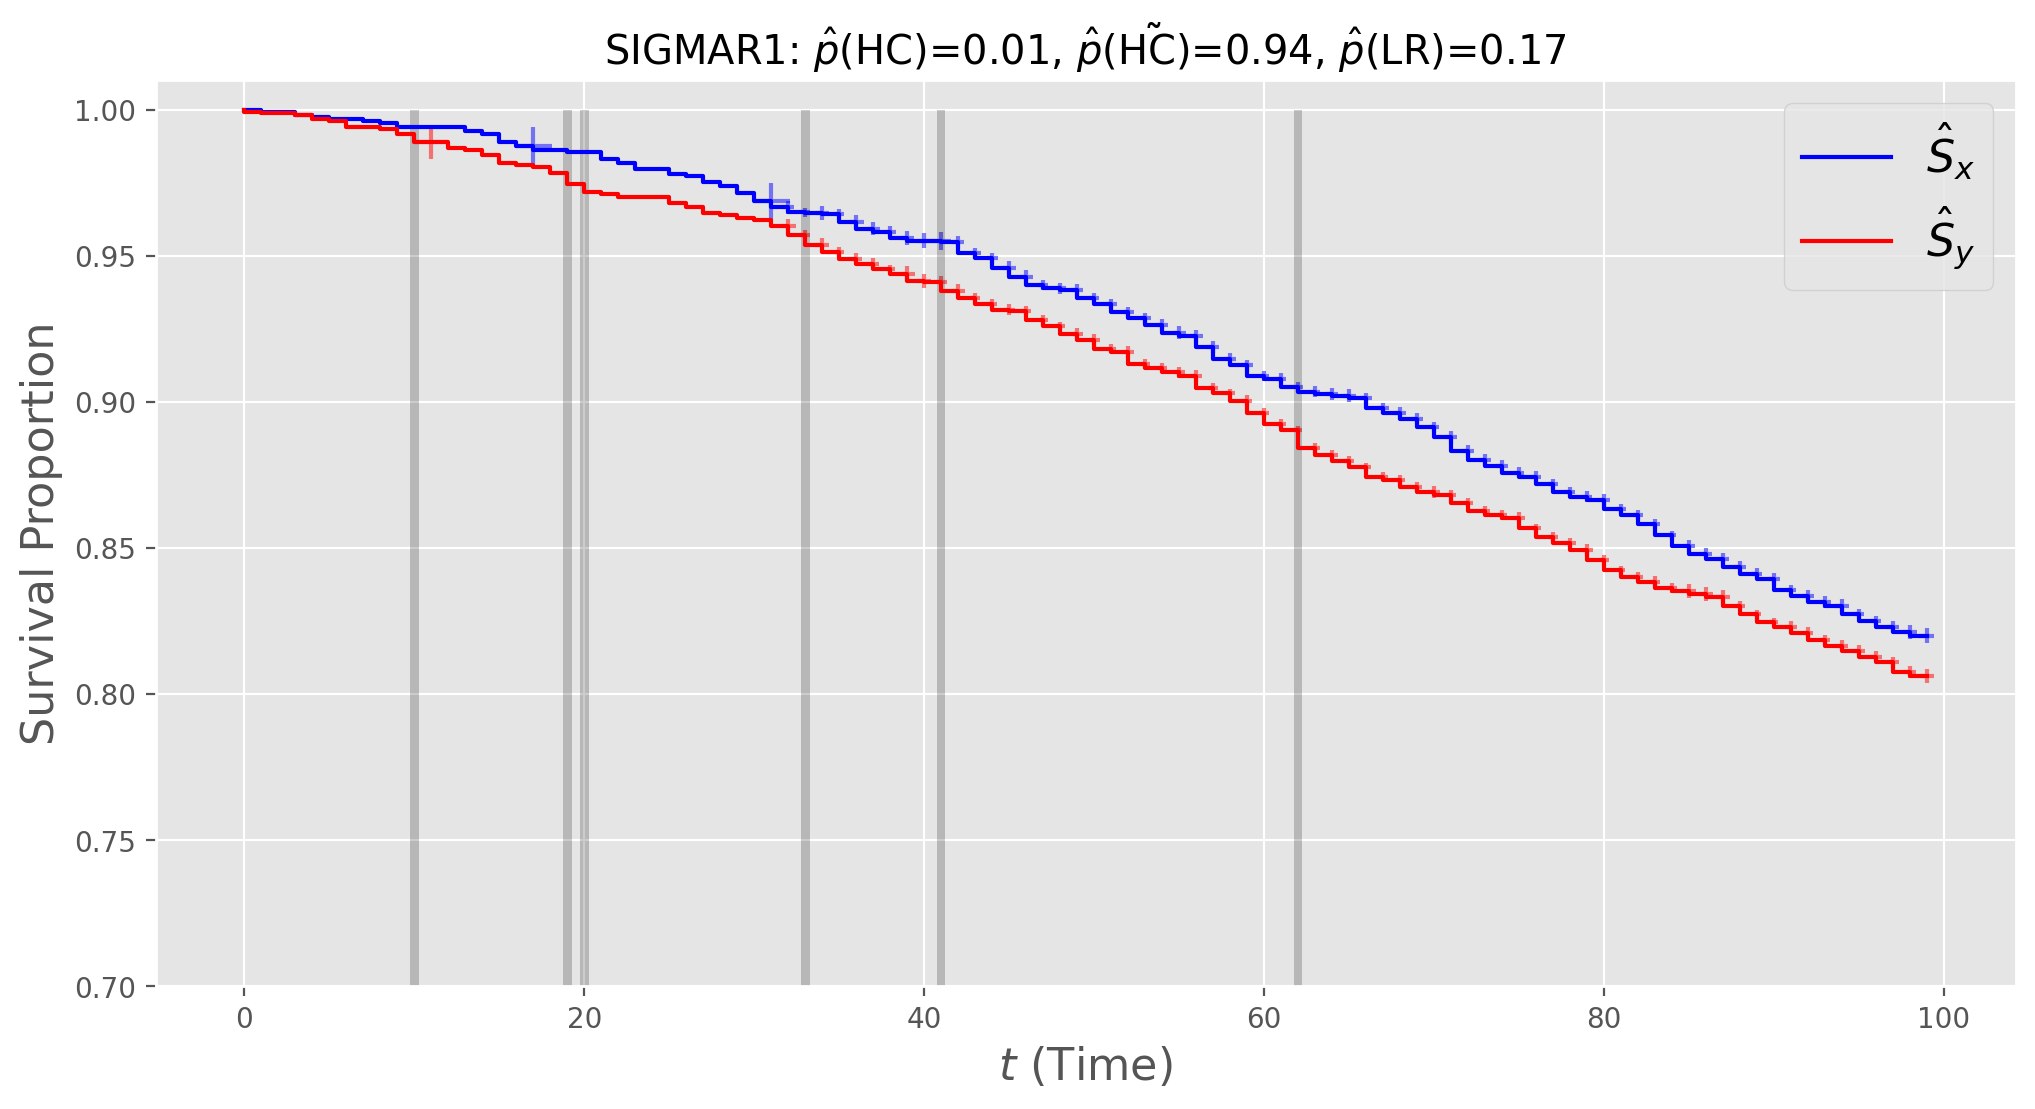

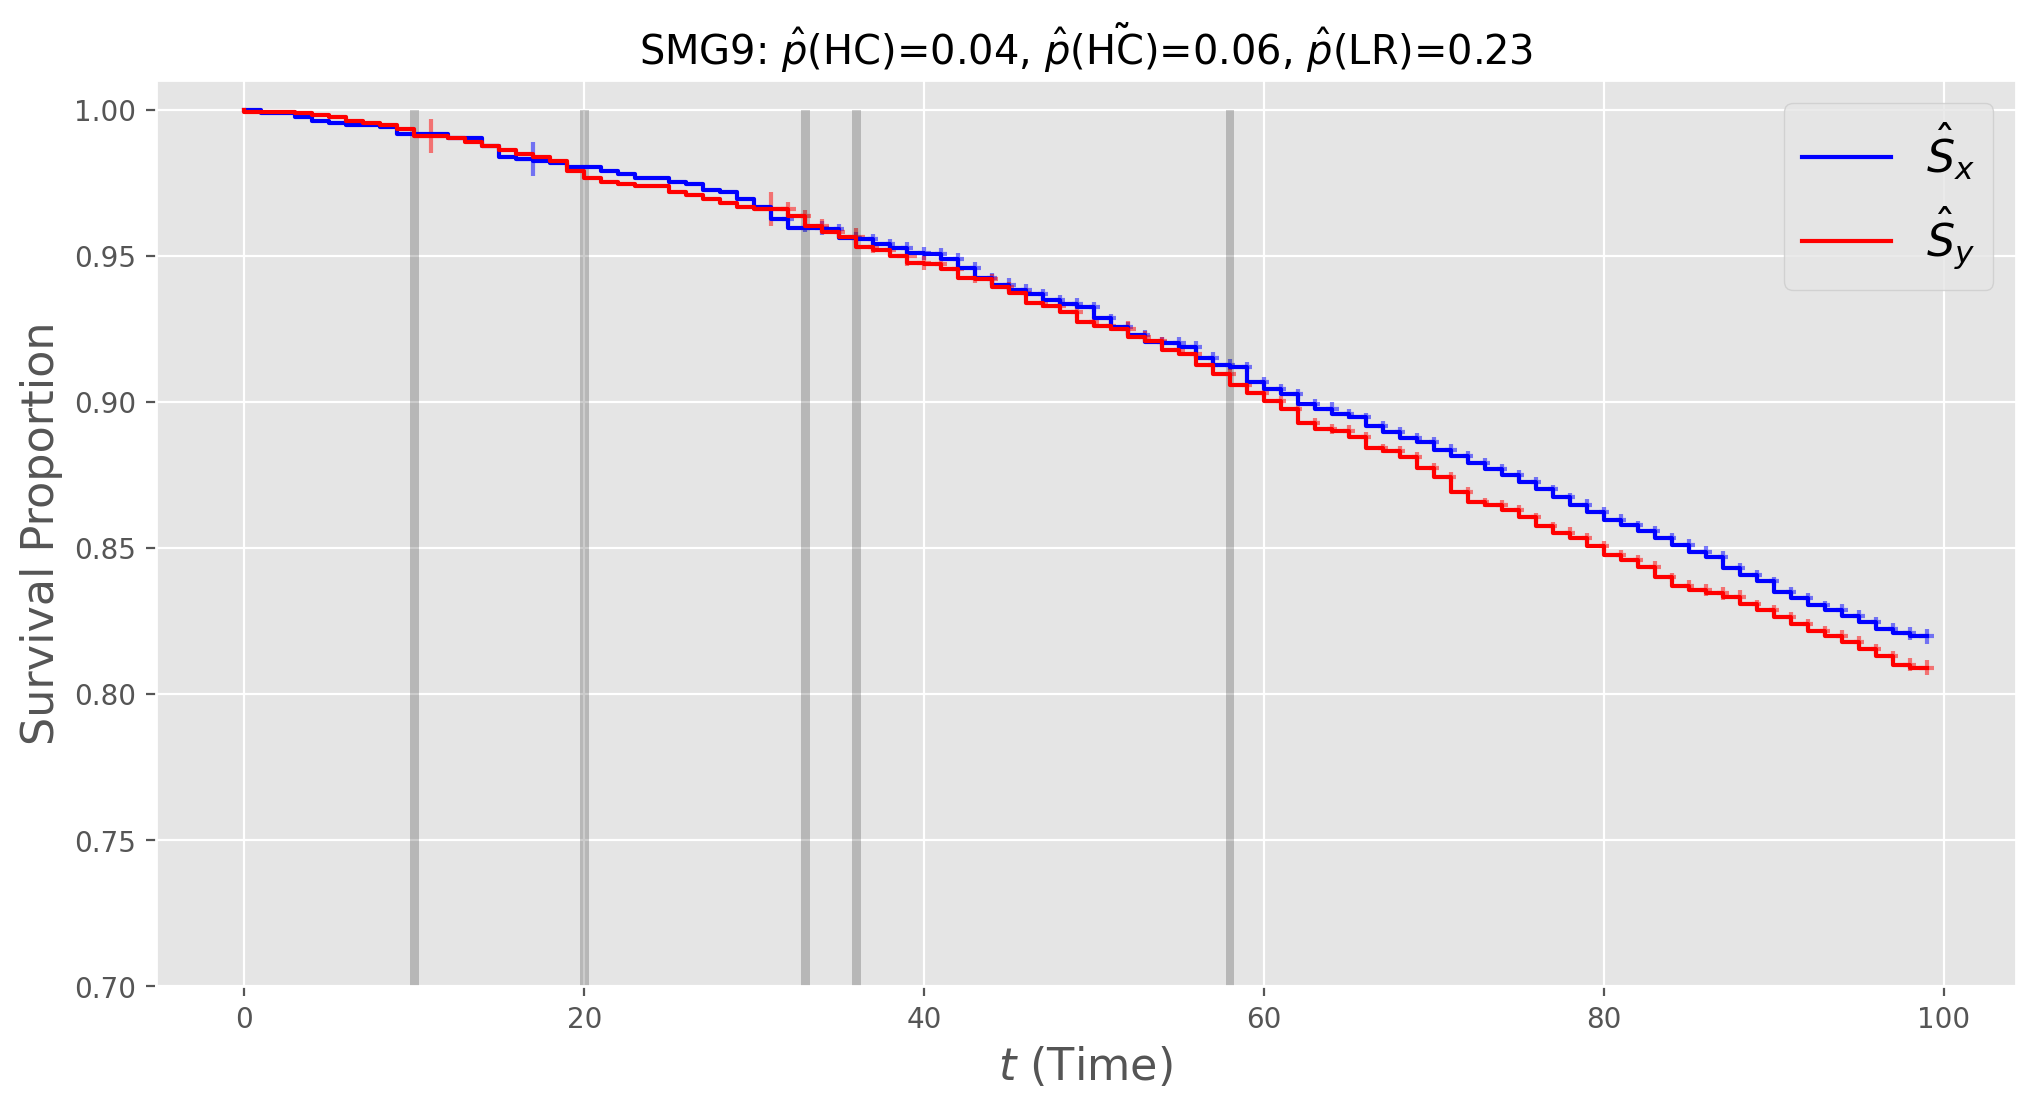

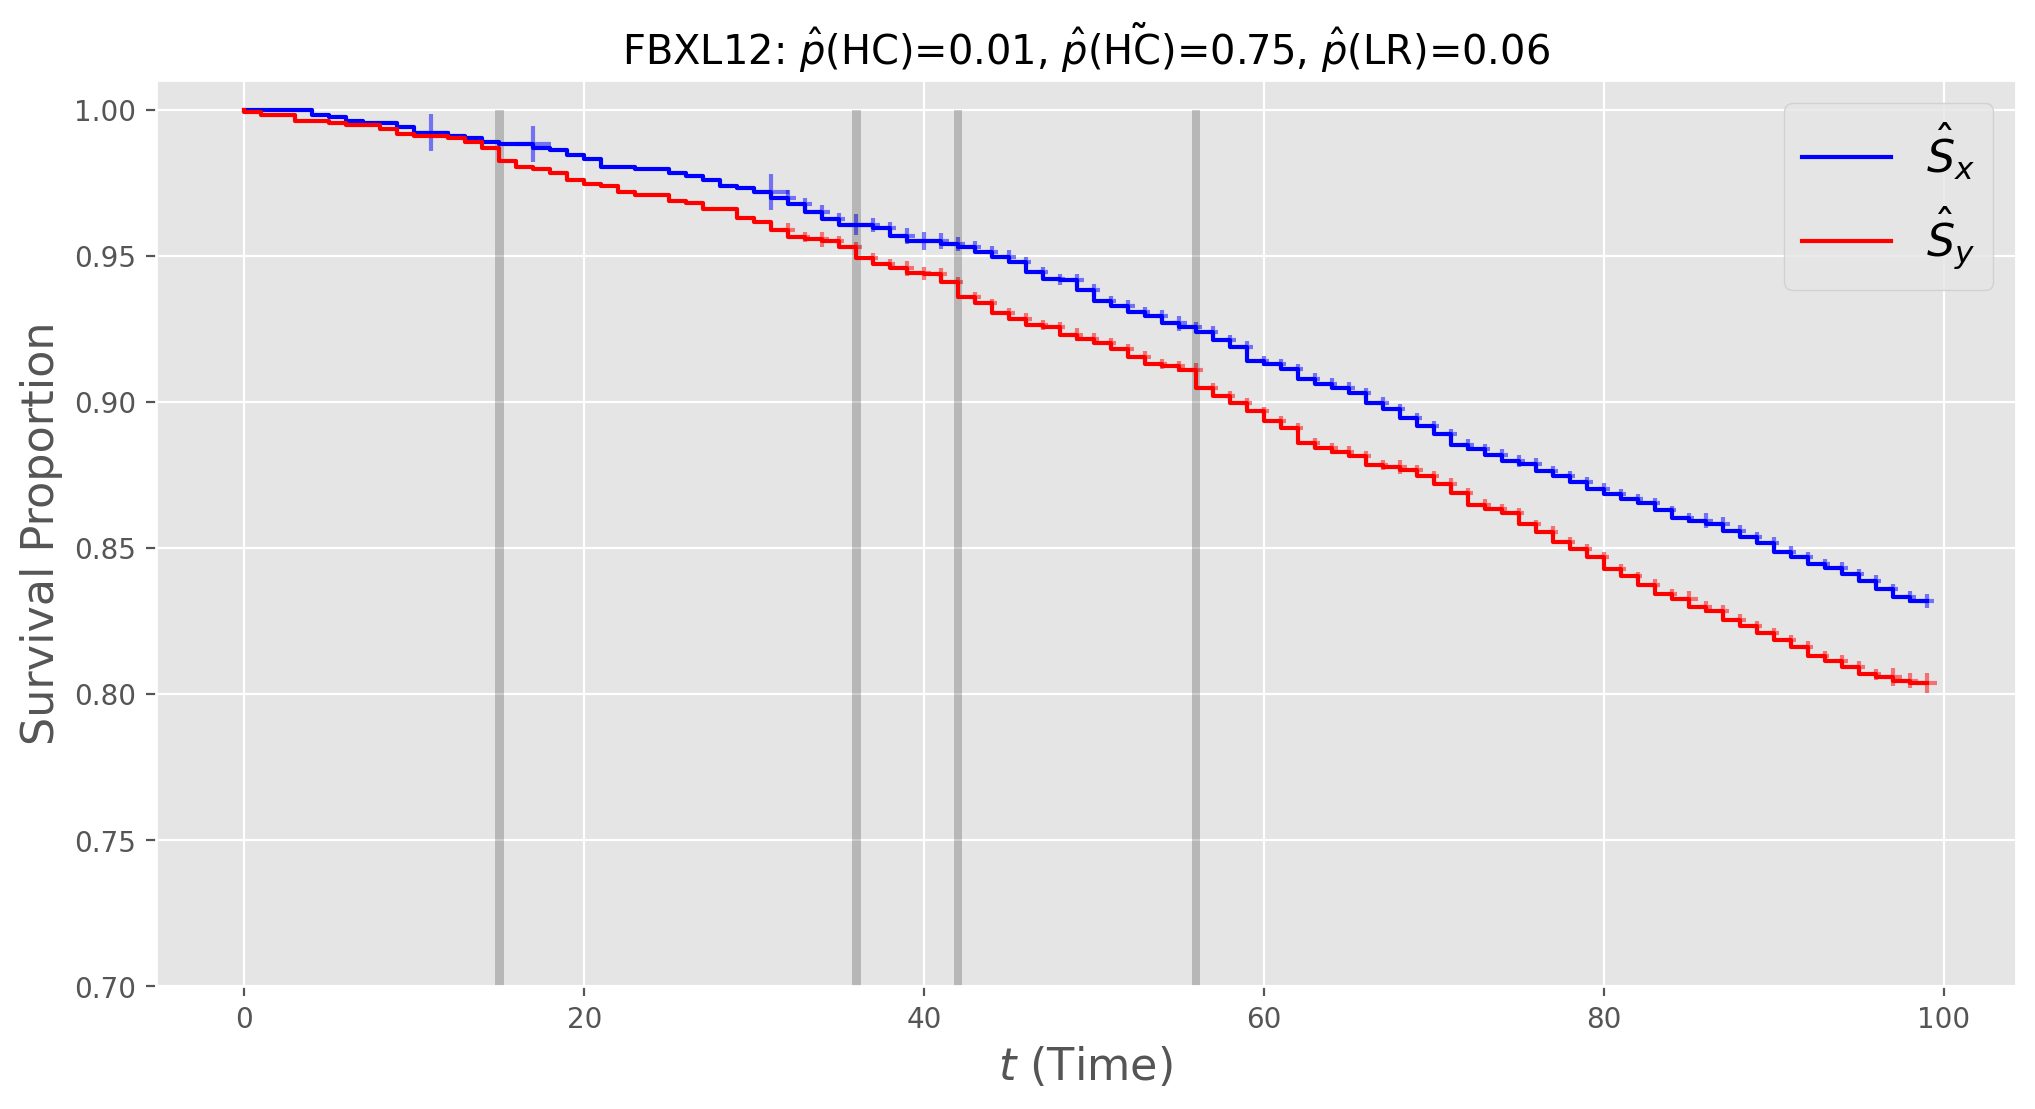

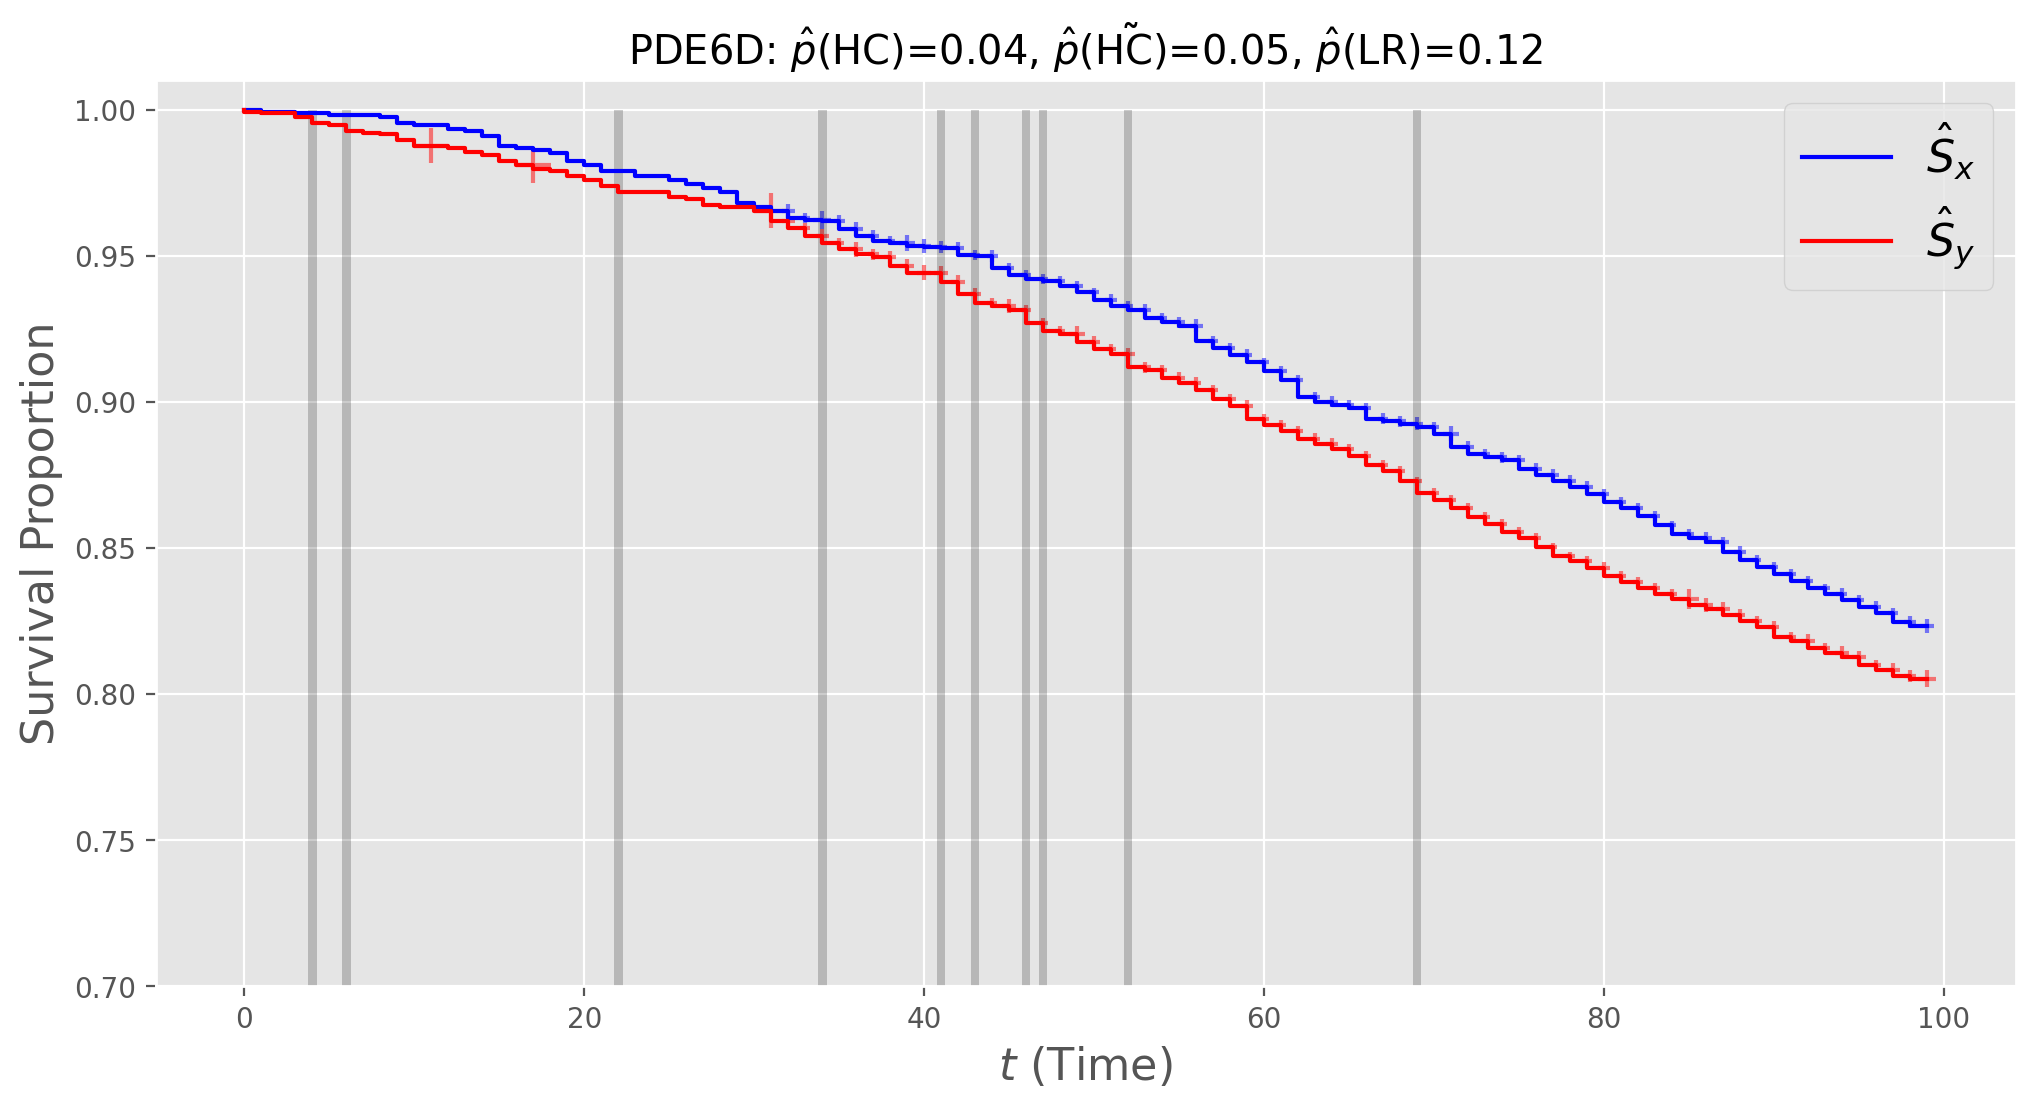

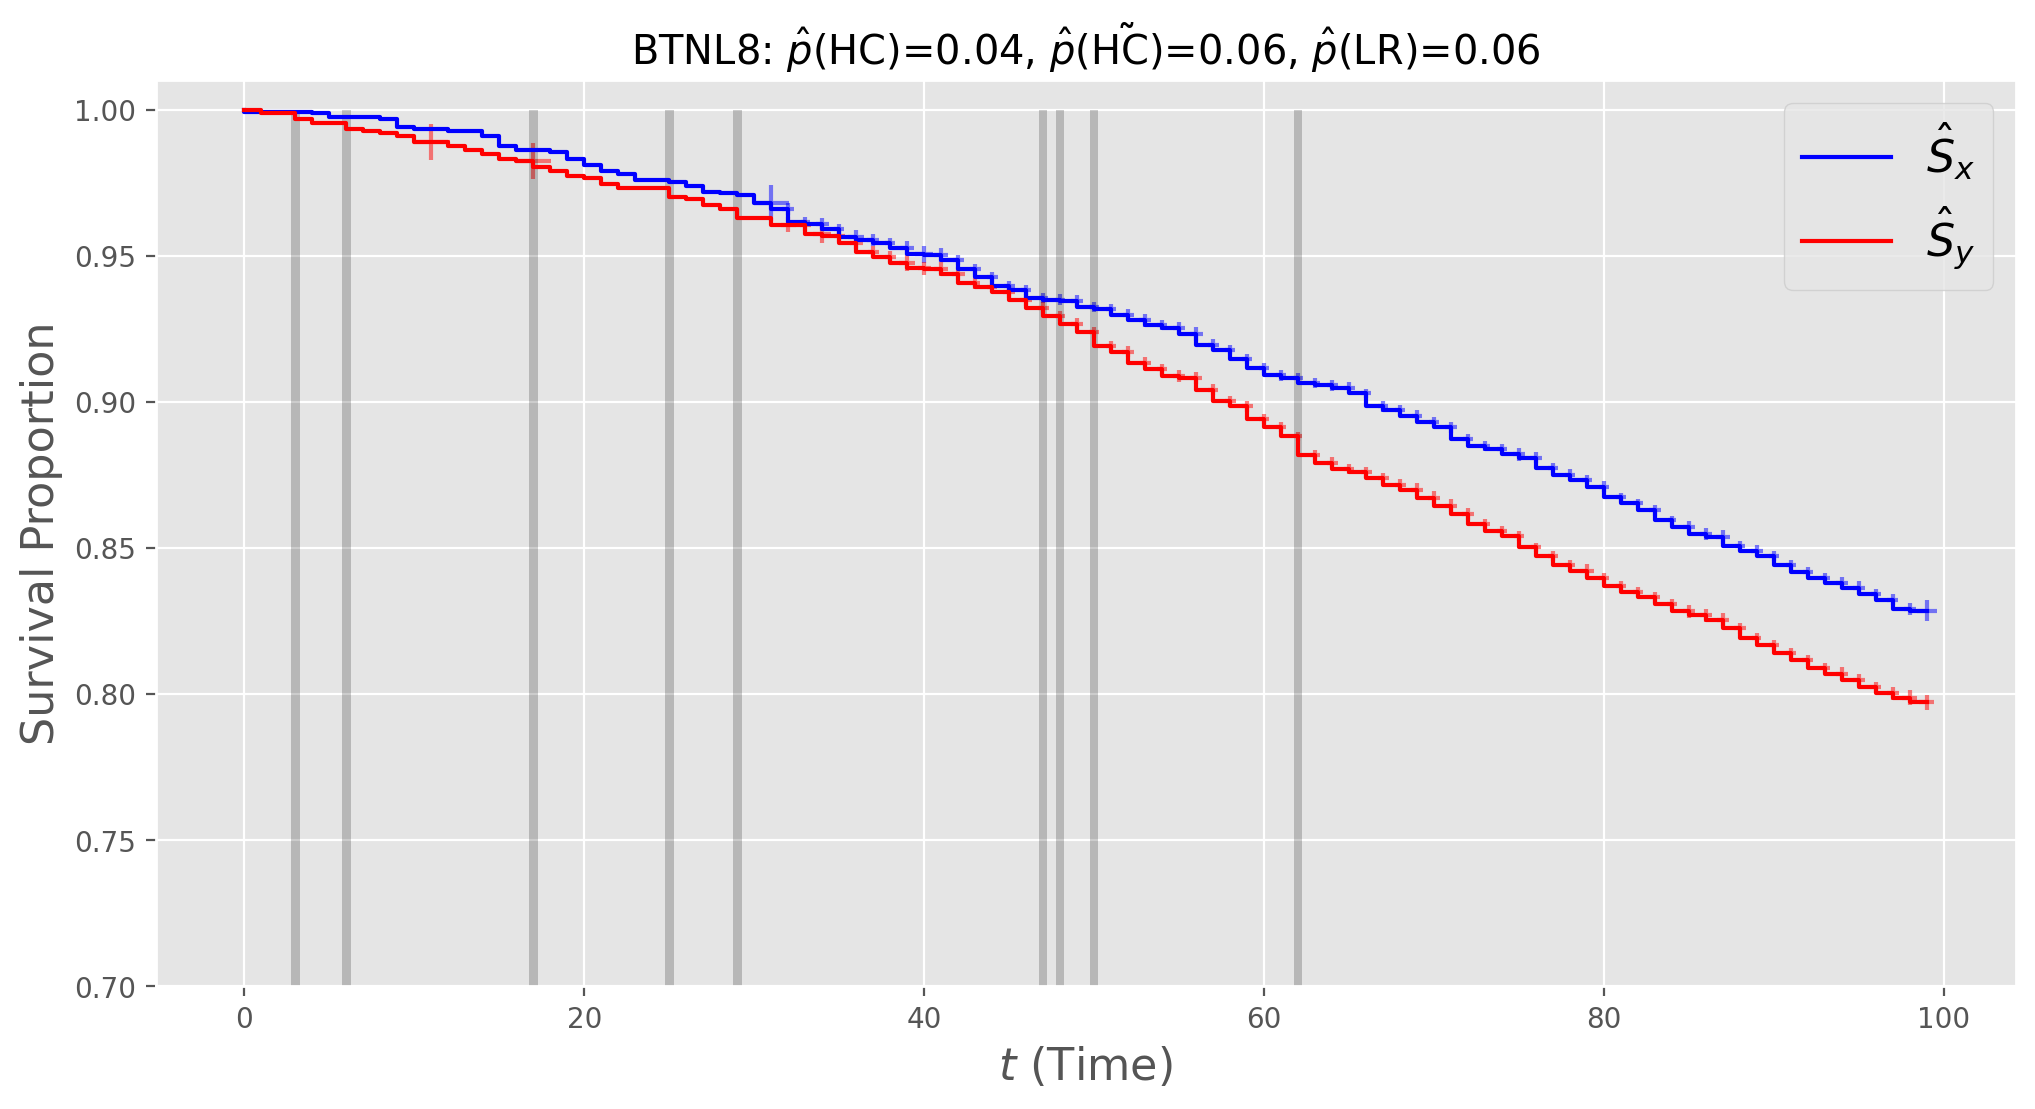

In [42]:
remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"

plt.rcParams['figure.figsize'] =  [12, 6]
plt.rcParams["figure.dpi"] = 200

for gene_name in resi_disp.name:
    df_disp, dfp = illustrate_survival_curve(df, gene_name, T, stbl=True)
    plt.savefig(remote_dir + "Figs/"  + gene_name + ".png")
    plt.show()

    dfd = df_disp.copy()
    dfd = dfd.iloc[:, :-2]

    for tag in ['pvalue', 'pvalue_rev']:
        dfd[tag] = np.round(dfd[tag],3)

    for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
        dfd[tag] = dfd[tag].astype(int)

    dfd.index.name = 'time'

    dfd.filter(['at-risk X', 'at-risk Y', 'events X', 'events Y', 'pvalue', 'pvalue_rev'])\
        .to_csv(remote_dir + "csv/" + f'{gene_name}.csv')


In [45]:
print("Saving SCANB results...")
path = remote_dir + "csv/results_SCANB.csv"

def prepare_for_display(resi_disp):
    flip_idc = resi_disp['hc_greater'] < resi_disp['hc_greater_rev']
    resi_disp['flip'] = '$>$ med'
    resi_disp.loc[flip_idc, 'flip'] = '$<$ med'
    resi_disp['hc'] = np.maximum(resi_disp['hc_greater'], resi_disp['hc_greater_rev'])
    resi_disp['log_rank'] = np.maximum(resi_disp['log_rank_greater'], resi_disp['log_rank_greater_rev'])
    rr = resi_disp.reset_index().filter(['name', 'hc', 'hc_pval', 'log_rank', 'log_rank_pval', 'flip'])

    return rr[rr['log_rank'] > 0.05]

df_disp = prepare_for_display(resi_disp).set_index('name')
df_disp.to_csv(path)
print(f"saved to {path}")


Saving SCANB results...
saved to /Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv/results_SCANB.csv


<ipython-input-45-969544c7c75e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resi_disp['flip'] = '$>$ med'
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-45-969544c7c75e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat